In [125]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [126]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import IPython
IPython.display.clear_output()


In [168]:
IMG_PATH = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/image/'
MSK_PATH = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/'

In [172]:
# Set dataset path
DATASET_PATH = "/kaggle/input/chest-x-ray-lungs-segmentation"

# Get all image and mask file paths
image_dir = os.path.join(IMG_PATH)
mask_dir = os.path.join(MSK_PATH)

image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")])

# Check total images and masks
print(f"Total Images: {len(image_paths)}, Total Masks: {len(mask_paths)}")


Total Images: 704, Total Masks: 704


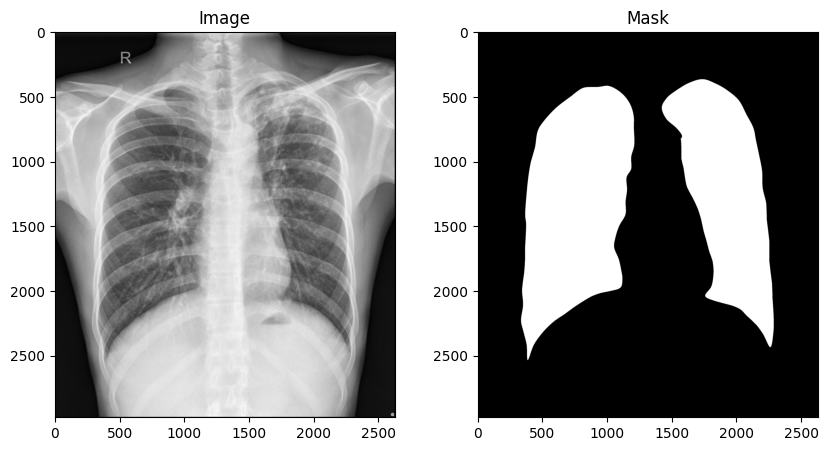

In [193]:
# Plot an image and its mask
idx = 18
image = cv2.imread(image_paths[idx], cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
mask = cv2.imread(mask_paths[idx], cv2.IMREAD_GRAYSCALE)    # Load mask as grayscale

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()

In [173]:
def load_data(image_path, mask_path):
    # Read image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Ensure grayscale
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize [0,1]

    # Read mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask, tf.uint8)  # Keep masks as integer labels

    return image, mask


In [174]:
# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

# Batch & prefetch
BATCH_SIZE = 32
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Split into train & validation
train_size = int(0.8 * len(image_paths))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Check dataset
for image, mask in train_dataset.take(1):
    print("Image shape:", image.shape)  # (batch_size, 256, 256, 1)
    print("Mask shape:", mask.shape)  # (batch_size, 256, 256, 1)


Image shape: (32, 256, 256, 1)
Mask shape: (32, 256, 256, 1)


In [183]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def squeeze_excitation_block(input_tensor, ratio=16):
    """ Squeeze-and-Excitation block for channel-wise attention. """
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation="relu")(se)
    se = layers.Dense(filters, activation="sigmoid")(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.multiply([input_tensor, se])

def unet_model(input_size=(256, 256, 1)):
    inputs = tf.keras.Input(shape=input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    c1 = squeeze_excitation_block(c1)  # Attention
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.3)(p1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    c2 = squeeze_excitation_block(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.3)(p2)

    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    c3 = squeeze_excitation_block(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.4)(p3)

    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c5 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c5)
    c5 = squeeze_excitation_block(c5)
    c5 = layers.BatchNormalization()(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.concatenate([u6, c3])
    c6 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c6)
    c6 = squeeze_excitation_block(c6)
    c6 = layers.BatchNormalization()(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.concatenate([u7, c2])
    c7 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c7)
    c7 = squeeze_excitation_block(c7)
    c7 = layers.BatchNormalization()(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = layers.concatenate([u8, c1])
    c8 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c8)
    c8 = squeeze_excitation_block(c8)
    c8 = layers.BatchNormalization()(c8)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c8)

    model = Model(inputs, outputs)
    return model

# Create and compile model
model = unet_model()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_184 (Conv2D)       │ (None, 256, 256, 64)   │            640 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_185 (Conv2D)       │ (None, 256, 256, 64)   │         36,928 │ conv2d_184[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ conv2d_185[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            260 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │            320 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 256, 256, 64)   │              0 │ conv2d_185[0][0],      │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_63    │ (None, 256, 256, 64)   │            256 │ multiply[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_41          │ (None, 128, 128, 64)   │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 128, 128, 64)   │              0 │ max_pooling2d_41[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_186 (Conv2D)       │ (None, 128, 128, 128)  │         73,856 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_187 (Conv2D)       │ (None, 128, 128, 128)  │        147,584 │ conv2d_186[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ conv2d_187[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8)              │          1,032 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │          1,152 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)  

 Total params: 7,757,593 (29.59 MB)

 Trainable params: 7,754,777 (29.58 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [184]:
# Compile model
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Train model
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,          
    restore_best_weights=True  # Restore model weights from best epoch
)

# Train model with Early Stopping
EPOCHS = 20
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]  )


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.5423 - loss: -512.3335
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.7182 - loss: -1158.0571
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.7222 - loss: -1409.4108
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.7213 - loss: -1665.9230
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.7237 - loss: -1931.9517
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.7254 - loss: -2208.0920
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.7254 - loss: -2502.4888
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.7252 - loss: -2808.7449
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.7245 - loss: -3133.9104
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.7248 - loss: -3489.7317
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.7260 - loss: -3862.2590
Epoch 12/20
22/22 ━━━━━━━━━━━━━

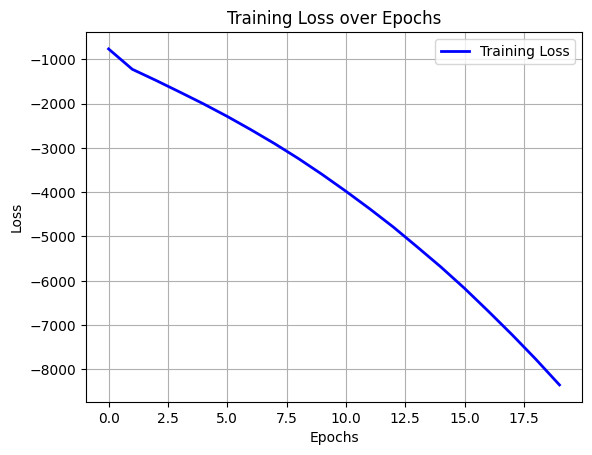

In [186]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)

# Labels and Title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [190]:
for image_batch, mask_batch in val_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Mask batch shape:", mask_batch.shape)


In [195]:
# Check the dataset length
num_batches = len(list(train_dataset))
print(f"Validation Dataset has {num_batches} batches")

# If it's empty, the dataset is not properly loaded
if num_batches == 0:
    print("Error: val_dataset is empty. Check dataset loading!")


Validation Dataset has 22 batches


In [199]:
import numpy as np

# Get a single batch from train_dataset
sample_batch = next(iter(train_dataset))  # Get first batch
single_image, single_mask = sample_batch  # Unpack

# Extract only the first image from the batch
single_image = np.expand_dims(single_image[4], axis=0)  # Ensure batch shape (1, 256, 256, 1)


In [200]:
# Predict the mask for the single image
pred_mask = model.predict(single_image)
pred_mask = (pred_mask > 0.5).astype("int")  # Convert to binary mask


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


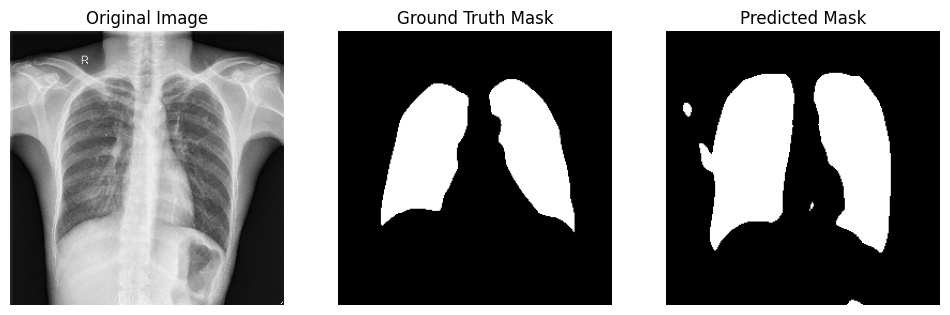

In [201]:
import matplotlib.pyplot as plt

# Function to plot the results
def display_prediction(image, ground_truth, prediction):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image[0, :, :, 0], cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth[0, :, :, 0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction[0, :, :, 0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Call function to display
display_prediction(single_image, single_mask, pred_mask)
